In [ ]:
# colab 사용 시! Local PC로 실습하는 경우 실행 x / 단, 작업경로를 2025_LGE_SSL로 맞춰주기

!git clone https://github.com/Im-JihyunKim/2025_LG_ES_SSL.git
%cd /content/2025_LG_ES_SSL

In [1]:
# !pip install IPython
from IPython.display import Image

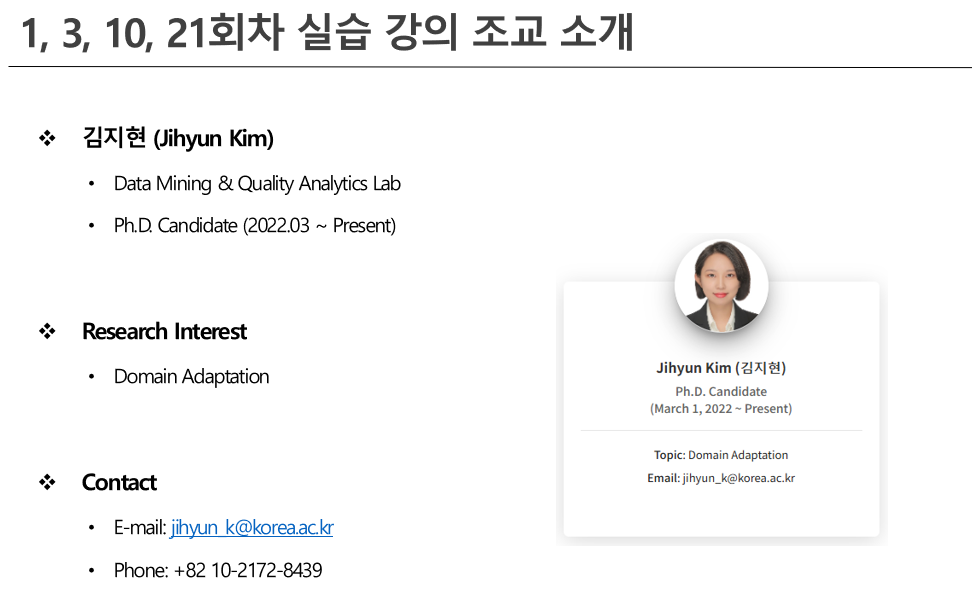

In [2]:
Image('./images/img0.png')

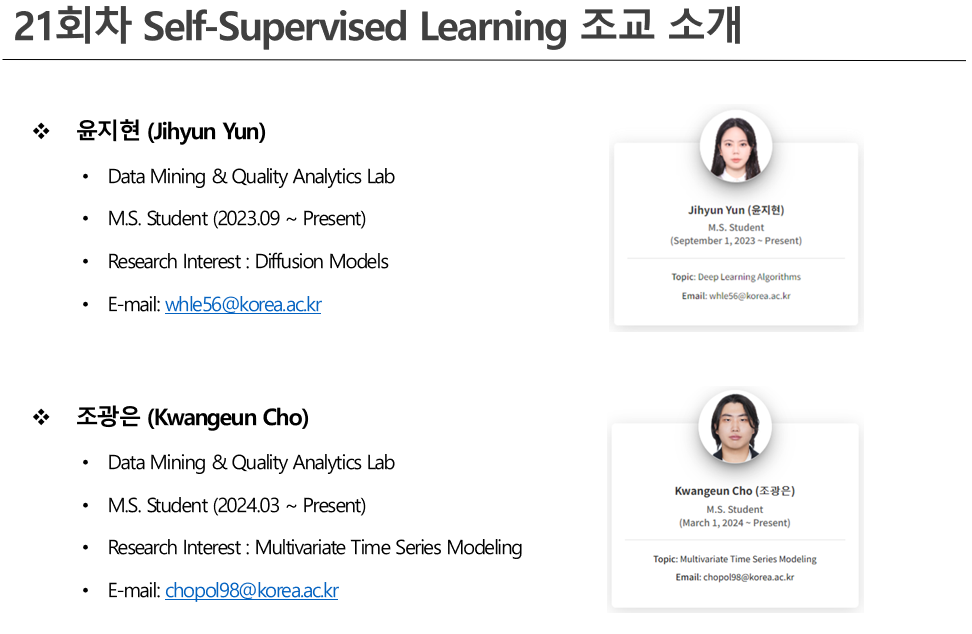

In [2]:
Image('./images/assist.png')

------

## Task: Self-supervised Learning - Non Contrastive Learning
### SimSiam

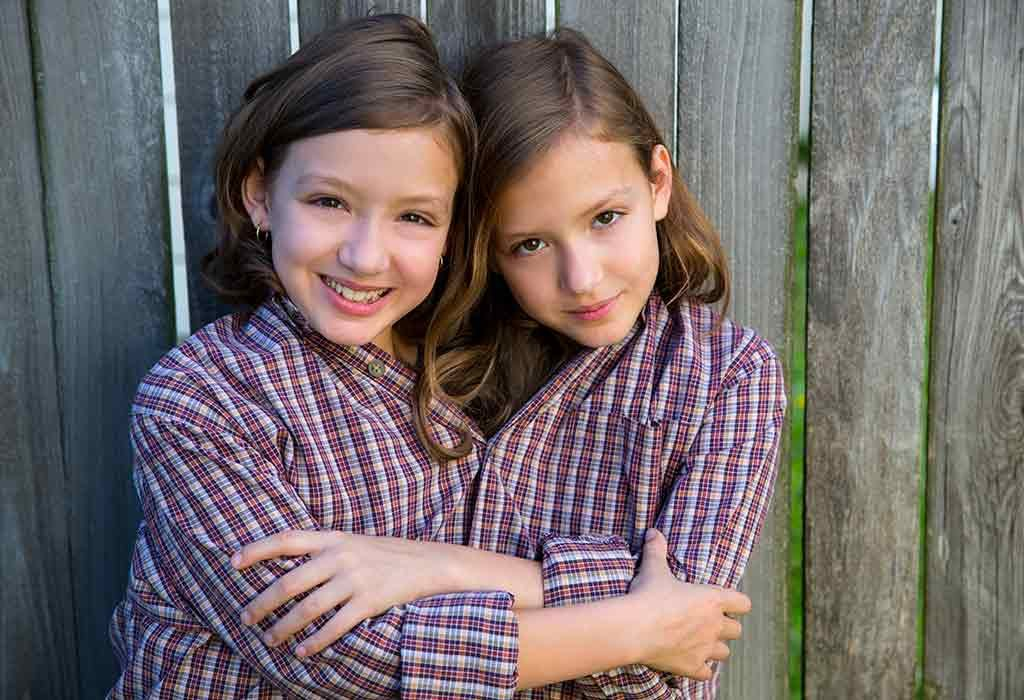

In [4]:
Image('images/simsiam_twins.jpg')

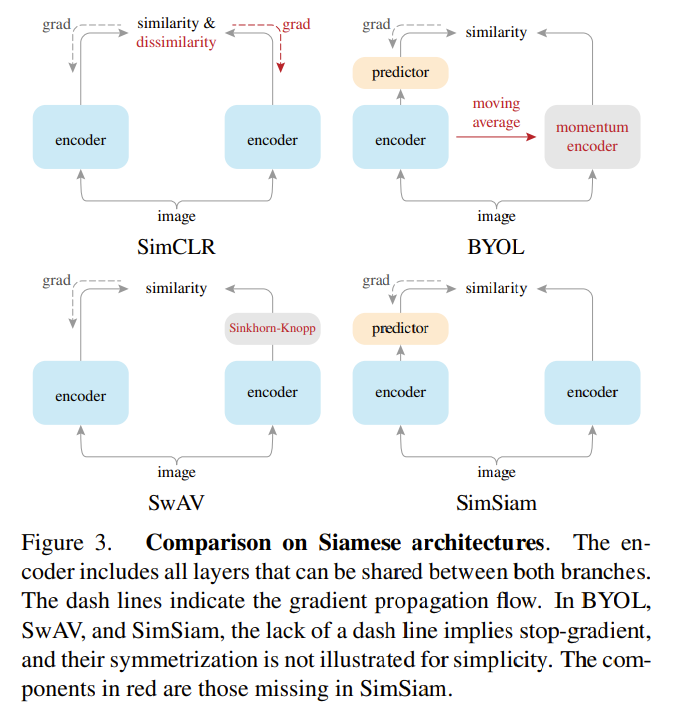

In [4]:
Image('./images/simsiam_framework.PNG')

- 동일한 encoder 구조 + **동일한 weights**까지 이용하기 때문에 코드 구현이 매우 용이한 장점!
- 더불어 positive sample만을 이용 가능! (큰 batch size일 필요 X)
- 모델 최적화도 용이!

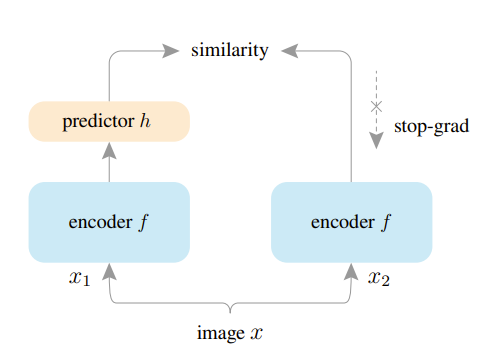

In [5]:
Image('./images/simsiam_framework2.PNG')

#### 연구 배경
- SimCLR -> contrastive learning을 위해 큰 batch size와 많은 negative samples이 필요
- BYOL -> positive samples만으로 학습 가능하지만 target network를 새로 정의해야 하는 구조적인 복잡함

##### 복잡한 구조 없이도 효과적인 표현 학습을 하는 방법?
- target network를 제거하고 단일 encoder를 사용
- 붕괴 방지를 위한 해결책으로, stop-gradient 연산 도입
    - 한 branch만 학습시키고, 다른 branch에서는 학습을 중단하자! (비대칭성)
- 마치 자기 자신과 가위바위보를 하는 꼴!

## 1. 필요 라이브러리 호출

In [3]:
import os, random, time
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision.models as models 
from torch.utils.data import Dataset, DataLoader, Subset 
from torchvision.transforms import transforms
from torchvision import transforms, datasets

import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

<Figure size 640x480 with 0 Axes>

## 2. Dataset 및 Dataloader 정의

### 실습 데이터셋: CIFAR10
- 32x32의 RGB 이미지로 구성된 데이터셋
- 10개의 class를 분류하는 image classification task에 주로 활용

 
(1) 전체 데이터 개수: 60,000개 (50,000개 학습용 / 10,000개 평가용)

- Class 10개: Plane / Car / Bird / Cat / Deer / Dog / Frog / Horse / Ship / Truck

(2) Pretraining Task: 50,000개

(3) Downstream Task: 10,000개 (Train: 8,000개 / Test: 2,000개)

- Validation은 별도로 구분하지 않음

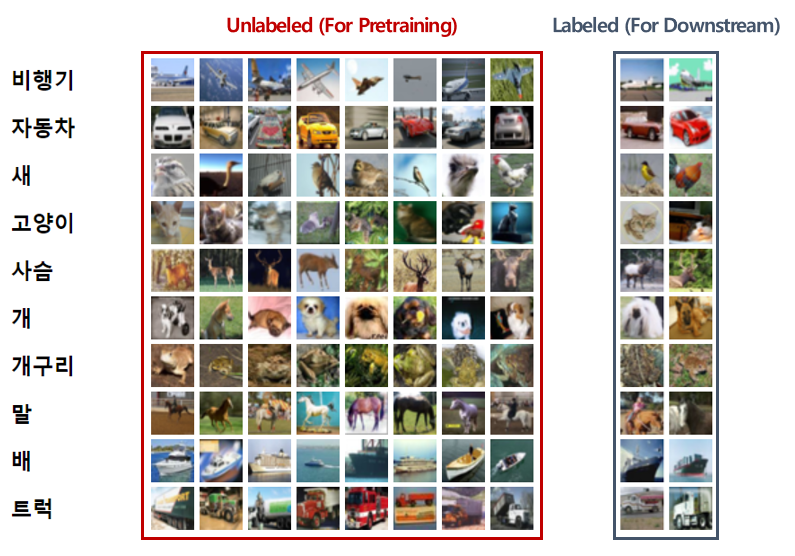

In [ ]:
Image('images/7-CIFAR102.PNG')

In [4]:
class CIFAR10Dataset(Dataset):
    def __init__(self, configs:dict, aug_generator:object):
        self.configs = configs
        self.data_dir = configs['data_dir']
        self.aug_generator = aug_generator

        # 저장 경로 폴더가 없는 경우 만들어주어야 함
        os.makedirs(self.data_dir, exist_ok=True)

    """For SimCLR : SimCLR 사전학습 시 사용되는 데이터셋"""
    def get_pretrain_dataset(self, n_views: int=2):
        pretrain_dataset = datasets.CIFAR10(self.data_dir, 
                                            train=True,  # train 여부
                                            transform=self.aug_generator(   # 사전에 정의한 augmented images generator 기반으로 transform 수행
                                                    base_transform=self.get_transform(),  # 사전에 정의한 이미지 변형 방법 적용
                                                    n_views=n_views),  # view는 하나의 동일한 이미지를 다른 시각으로 본다는 의미로, number of views 만큼 augmentation 수행
                                            download=True)
        return pretrain_dataset
    
    """For Downstream task : Downstream 지도학습에 사용되는 데이터"""
    def get_dataset(self, mode: str='train'):
        downstream_dataset = datasets.CIFAR10(self.data_dir,
                                             train=False,   # train 여부
                                             transform=transforms.Compose([
                                                        transforms.ToTensor(),    # 이미지를 tensor 타입으로 바꾸어줌
                                                        transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
                                                                mean=(0.4914, 0.4822, 0.4465),
                                                                std=(0.2023, 0.1994, 0.2010))
                                                                ]),
                                             download=True)
        
        train_idx, test_idx = train_test_split(list(range(len(downstream_dataset))), 
                                               test_size=0.2,
                                               random_state=self.configs['seed'])

        if mode == 'train':
            train_dataset = Subset(downstream_dataset, train_idx)  # 8,000개
            return train_dataset
        
        elif mode == 'test':
            test_dataset = Subset(downstream_dataset, test_idx)    # 2,000개
            return test_dataset
        
        else:
            raise NotImplementedError("'mode' should be one of ['train' or 'test']")
        
    @staticmethod  # 해당 클래스에서만 사용되는 메소드
    def get_transform(s:float=.5):
        """
        Return a set of data augmentation transformations 
        as described in the SimCLR paper.
        - SImCLR에서는 augmentation에 대해서 'random crop and resize', 'color distortion', 'blur'가 결합된 augmentation이 좋은 성능을 도출한다고 설명
        """
        normalize = transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
            mean=(0.4914, 0.4822, 0.4465),
            std=(0.2023, 0.1994, 0.2010)
        )

        # s is the strength of color distortion (0.5 for CIFAR10 by default)
        color_jitter = transforms.ColorJitter(0.8*s, 
                                              0.8*s,
                                              0.8*s,
                                              0.2*s)
        
        # See Section B.9 of SimCLR: https://arxiv.org/abs/2002.05709
        data_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size=32),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),  # 이미지 데이터 텐서화
            normalize,              # 앞서 정의한 이미지 정규화 수행
        ])

        return data_transforms

In [5]:
"""사전에 정의한 transform 방식을 기반으로 증강된 이미지를 반환해주는 class"""
class aug_generator(object):
    """
    Take 2 random crops of one image as the query and key.
    """
    def __init__(self, base_transform, n_views: int=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):  # aug_generator 클래스 호출 시 수행되는 함수
        return [self.base_transform(x) for i in range(self.n_views)]  # n_views 만큼 base_transform(get_transform 메소드에서 정의된 증강기법)을 수행하라

--------

## 4. SimSiam 모델 정의

In [6]:
class SimSiam(nn.Module):
    def __init__(self, configs):
        super(SimSiam, self).__init__()
        self.configs = configs
        self.device = configs['device']

        self.backbone = configs['backbone']
        self.hidden_dim = configs['hidden_dim']
        self.projection_dim = configs['projection_dim']

        self.cosine_sim = nn.CosineSimilarity(dim=1).to(self.device)

        ## Base encoder 선정
        # load model from torchvision.models without pretrained weights.
        resnet_dict = {
            'resnet18': models.resnet18(pretrained=False),   
            'resnet50': models.resnet50(pretrained=False)
        }
        self.encoder = resnet_dict[self.backbone]

        # Customize for CIFAR10. Replace conv 7z7 with conv 3x3, and remove first max pooling
        self.encoder.conv1 = nn.Conv2d(in_channels=3,
                                       out_channels=64, 
                                       kernel_size=3, 
                                       stride=1, 
                                       padding=1, 
                                       bias=False)
        
        self.encoder.maxpool = nn.Identity()  # 입력과 동일한 tensor를 출력으로 내보내주는 layer

        """get feature dim from in_features in fc-layer for resnet18 in torchvision"""
        feature_dim = self.encoder.fc.in_features  # resnet18.fc.in_features=256
        self.encoder.fc = nn.Identity()  # remove final fully connected layer

        # Add MLP projection
        self.projector = nn.Sequential(
            nn.Linear(feature_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden_dim, self.projection_dim),
            nn.BatchNorm1d(self.projection_dim),

        )

        # Add MLP predictor
        """page 3 baseline setting
        Prediction MLP. The prediction MLP (h) has BN applied 
        to its hidden fc layers. Its output fc does not have BN
        (ablation in Sec. 4.4) or ReLU. This MLP has 2 layers. 
        The dimension of h’s input and output (z and p) is d = 2048, 
        and h’s hidden layer’s dimension is 512, making h a 
        bottleneck structure (ablation in supplement). 
        """
        self.predictor = nn.Sequential(
            nn.Linear(self.projection_dim, self.projection_dim//2), 
            nn.BatchNorm1d(self.projection_dim//2),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_dim//2, self.projection_dim)
        )

    def forward(self, img1, img2):
        loss = self.simsiam_loss(img1, img2)
        return loss
    
    def encode(self, img):
        H = self.encoder(img)
        Z = self.projector(H)
        return Z
    
    def simsiam_loss(self, 
                  batch_view_1: torch.FloatTensor, 
                  batch_view_2: torch.FloatTensor):
        """
        loss:
        Extract features with the backbone and applies the projection head and prediction head
        to the output space. If both batch_view_1 and batch_view_2 are not None, both will be passed through the backbone, projection,
        and prediction head. If batch_view_2 is None, only batch_view_1 will be forwarded.

        See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
        """
        
        Z1 = self.encode(batch_view_1).detach() # stop gradient
        Z2 = self.encode(batch_view_2).detach() # stop gradient

        P1, P2 = self.predictor(Z1), self.predictor(Z2)

        # negative cosine sim loss
        ## (p1, z2), (p2, z1) 간의 코사인 유사도를 각각 계산 후 이를 minimize
        ## 유사도는 높을 수록 좋음 -> negative를 붙이면 낮을 수록 좋음
        loss = -(self.cosine_sim(P1, Z2).mean() + self.cosine_sim(P2, Z1).mean()) * 0.5

        return loss.mean()

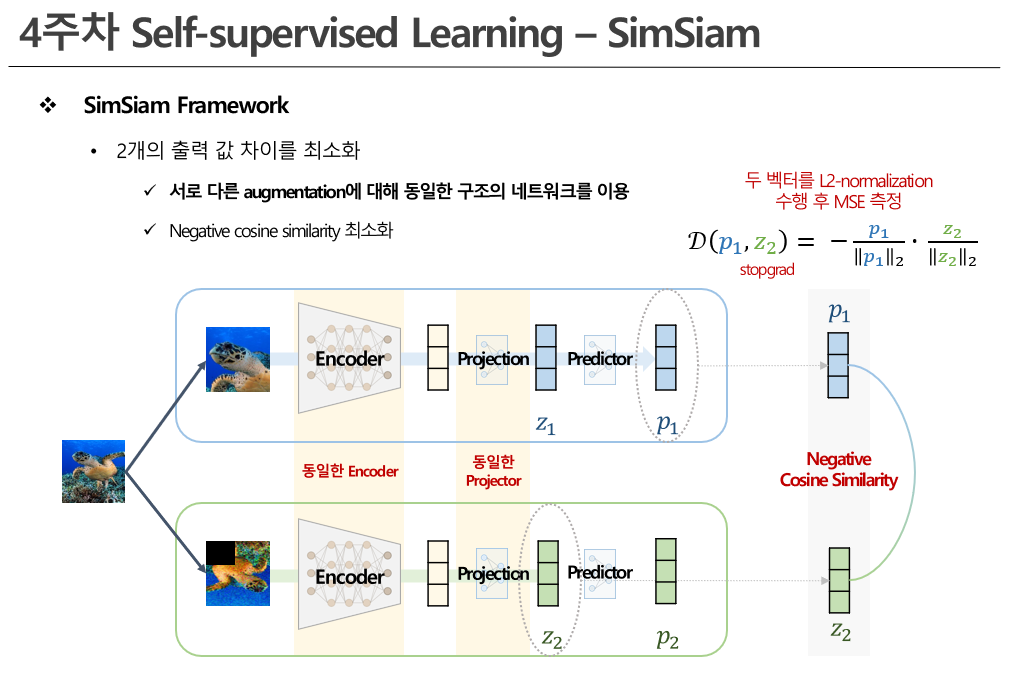

In [4]:
Image('./images/simsiam1.PNG')

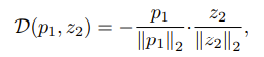

In [10]:
Image('./images/simsiam_loss1.PNG')

Z2 = self.encode(batch_view_2)
P1 = self.predictor(Z1)

-(self.cosine_sim(P1, Z2.detach()).mean())    # detach() -> stop gradient

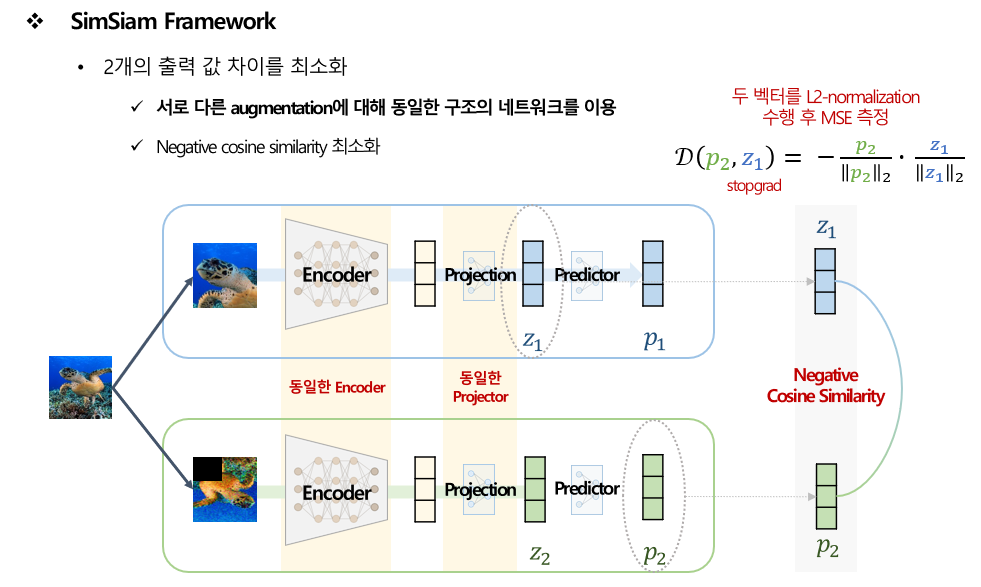

In [5]:
Image('./images/simsiam2.PNG')

Z1 = self.encode(batch_view_1)
P2 = self.predictor(Z2)

-(self.cosine_sim(P2, Z1.detach()).mean())    # detach() -> stop gradient

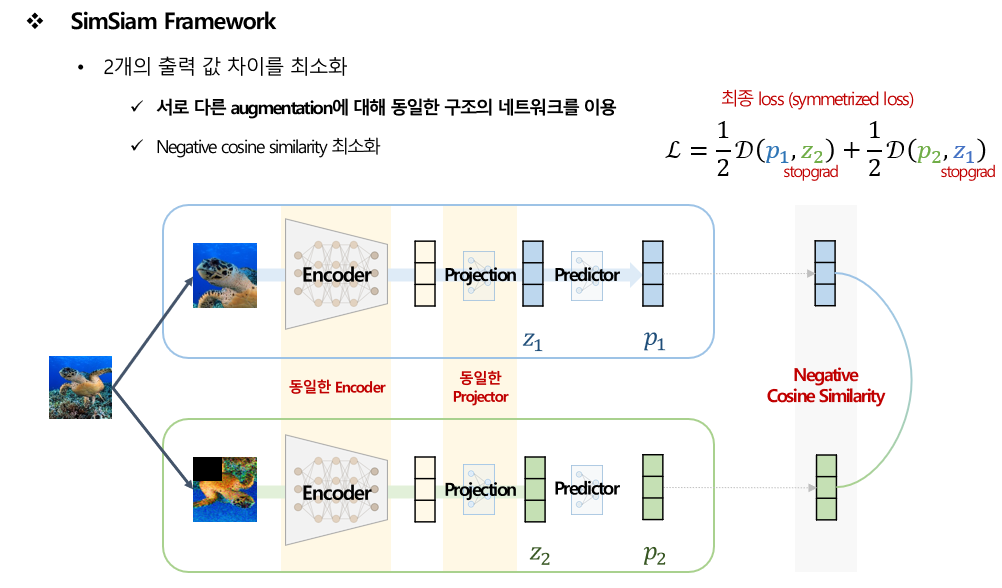

In [6]:
Image('./images/simsiam3.PNG')

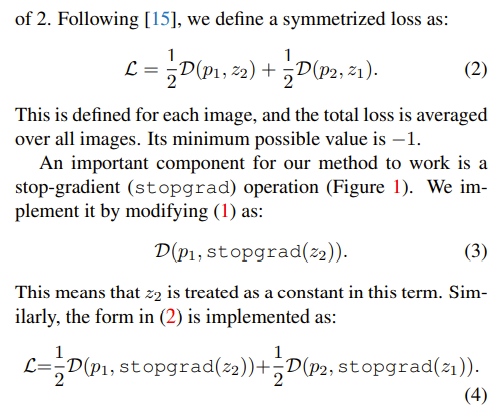

In [11]:
Image('./images/simsiam_loss2.PNG')

-------

## 4. 모델 학습

### Optimizer 정의

In [7]:
def get_optimizer(configs, model):
    if configs['optimizer'] == "sgd":
        optimizer = torch.optim.SGD(params=model.parameters(), lr=configs['lr'],
                              momentum=0.9, weight_decay=configs['weight_decay'])

    elif configs['optimizer'] == "adam":
        optimizer = torch.optim.Adam(params=model.parameters(), lr=configs['lr'], 
                                    weight_decay=configs['weight_decay'])
    else:
        print("Invalid optimizer name, it should be one of ['sgd', 'adam']. Exiting...")
        exit()

    return optimizer

### 모델 학습 추세 시각화 함수 정의

In [8]:
def visualize_model_training(epoch_history):
    # Loss 추세 시각화
    sns.lineplot(x=range(1, len(epoch_history['loss'])+1), y=epoch_history['loss'], label="Pretrain Loss")
    plt.title("Pretrain Loss Graph")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc="best")
    plt.show()

### 사전학습 과정 함수화

In [9]:
def pretrain(device, model, pretrain_loader, optimizer):
    model.train()
    num_iterations = len(pretrain_loader)
    pretrain_history = {'loss': torch.zeros(num_iterations)}

    for i, (img, _) in enumerate(pretrain_loader):
        """사전학습 단계에서는 X 데이터만 batch로 받을 수 있음! (y는 없음)"""

        # 증강된 두 데이터 불러오기
        img_aug_1, img_aug_2 = img[0].to(device), img[1].to(device)

        # loss 계산!
        loss = model(img_aug_1, img_aug_2)

        loss.backward()
        optimizer.step()       # optimizer를 이용한 파라미터 업데이트
        optimizer.zero_grad()  # Optimizer Gradient 초기화

        pretrain_history['loss'][i] = loss.item()

    pretrain_history = {k: v.mean().item() for k, v in pretrain_history.items()}

    return pretrain_history

### `main()` 함수를 통한 학습 수행

In [10]:
# 똑같은 결과를 얻기 위한 시드 고정
def set_seed(seed:int=0):
    torch.manual_seed(seed) # torch cpu seed 고정
    torch.cuda.manual_seed(seed) # torch gpu seed 고정
    torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(seed) # numpy seed 고정
    random.seed(seed)    # python seed 고정
    os.environ['PYTHONHASHSEED'] = str(seed)

In [11]:
def main(configs):
    """Step 1: 학습 전 세팅: device, seed, configs 확인, data 정의, model 정의, loss function 및 optimizer 정의"""
    device = configs['device']  # Device 정의
    set_seed(configs['seed'])   # seed 정의

    # 우리가 설정한 하이퍼파라미터가 무엇인지 프린트하여 확인
    print(f"Configurations: \n {configs}")

    # 학습 결과를 저장할 경로 설정
    save_dir = os.path.join(configs['save_dir'], 'Pretrain')
    # make checkpoint directory
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    ### 데이터셋 정의
    dataset = CIFAR10Dataset(configs, aug_generator)
    pretrain_dataset = dataset.get_pretrain_dataset(n_views=2)
    pretrain_loader = DataLoader(
        dataset=pretrain_dataset,
        batch_size=configs['batch_size'],
        shuffle=True,
        num_workers=0,
        drop_last=False
    )

    ### Model Architecture 정의
    model = SimSiam(configs).to(device)

    ### optimizer
    optimizer = get_optimizer(configs, model)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer=optimizer,
        T_max=configs['num_epochs'],
        eta_min=configs['lr']*1e-2
    )

    # Pretraining
    epoch_history = {'loss': []}
    
    start = time.time()

    """Step 2: 사전학습 시작"""
    for epoch in range(1, configs['num_epochs']+1):
        print('-'*15, f'Epoch: {epoch}', '-'*15)

        pretrain_result = pretrain(device, model, pretrain_loader, optimizer)
        lr_scheduler.step()

        print(f"Loss: {pretrain_result['loss']:.2f}")

        """Step 3: 학습 중 도출된 loss 및 acc 값들 저장"""
        epoch_history['loss'].append(pretrain_result['loss'])

    """last epoch에서 checkpoint 저장"""
    torch.save(model.encoder.state_dict(), os.path.join(save_dir, 'pretrained_SimSiam.pt'))

    ## 학습 추세 시각화
    if configs['visualize']:
        visualize_model_training(epoch_history)

    # 사전학습에 소요된 시간 계산 후 출력
    end_sec = time.time() - start
    end_min = end_sec / 60
    print(f"Total Training Time: {end_min:.2f} minutes")

    return model

Configurations: 
 {'device': device(type='cuda'), 'seed': 0, 'data_dir': './data/', 'save_dir': './results/SimSiam', 'batch_size': 256, 'backbone': 'resnet18', 'hidden_dim': 1024, 'projection_dim': 1024, 'num_epochs': 10, 'optimizer': 'sgd', 'lr': 0.005, 'weight_decay': 0.0005, 'visualize': True}
Files already downloaded and verified
--------------- Epoch: 1 ---------------
Loss: -0.08
--------------- Epoch: 2 ---------------
Loss: -0.15
--------------- Epoch: 3 ---------------
Loss: -0.17
--------------- Epoch: 4 ---------------
Loss: -0.18
--------------- Epoch: 5 ---------------
Loss: -0.19
--------------- Epoch: 6 ---------------
Loss: -0.19
--------------- Epoch: 7 ---------------
Loss: -0.19
--------------- Epoch: 8 ---------------
Loss: -0.19
--------------- Epoch: 9 ---------------
Loss: -0.19
--------------- Epoch: 10 ---------------
Loss: -0.19


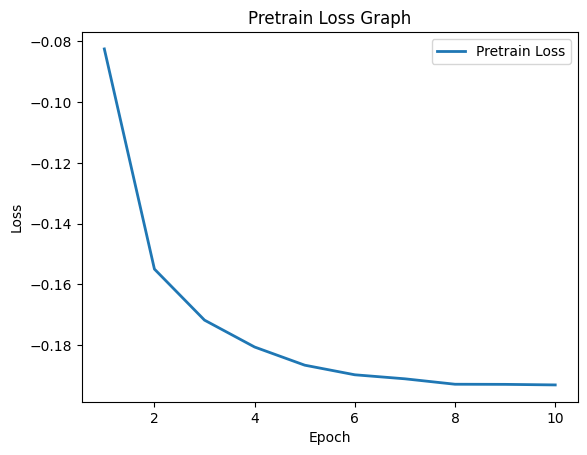

Total Training Time: 6.24 minutes


In [12]:
if __name__ == '__main__':
    configs={
        # basic setting
        'device':torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
        'seed':0,

        # dataset hyperparameters
        'data_dir':'./data/',
        'save_dir':'./results/SimSiam',
        'batch_size':256,

        # model hyperparameters
        'backbone':'resnet18',
        'hidden_dim':1024,
        'projection_dim':1024,

        # training hyperparameters
        'num_epochs':10,
        'optimizer':'sgd',
        'lr':5e-3,
        'weight_decay':5e-4,
        'visualize':True
    }
    
    pretrained_model = main(configs)

----------------------------------

## 5. Downstream Task

### 모델 성능 평가 지표 정의

In [13]:
def accuracy(output: torch.FloatTensor,
             target: torch.LongTensor,
             topk: tuple=(1, )):
    
    ### max_k기준 correct 여부 판별
    with torch.no_grad():
        max_k = max(topk) 
        batch_size = target.size(0) 
        _, pred = output.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred)) ### eq: 동일여부 판별

        ### 확인하고 싶은 topk 지표들을 모두 산출 
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        
        return res

In [14]:
""" 1. 미세조정 (Downstream Task) 학습 알고리즘 정의 """
class Downstream(object):

    ### 학습에 필요한 값들 초기화
    def __init__(self, device, encoder, classifier, optimizer, **kwargs):
        self.device = device
        self.encoder = encoder.to(device)   
        self.classifier = classifier.to(device)
        self.optimizer = optimizer
        self.criterion = nn.CrossEntropyLoss().to(device)
        self.__dict__.update(kwargs)

    ### Downstream Task 학습 알고리즘
    def train_test(self, train_loader, test_loader):

        ### Train 모드 
        for epoch in range(self.epochs):
            top1_train_acc, train_loss = 0, 0
            for i, (images, targets) in enumerate(train_loader):

                ### 데이터를 Batch 단위로 불러오기
                images = images.to(self.device)
                targets = targets.to(self.device)

                ### 사전학습된 Encoder에 데이터 통과
                if self.downstream: ### Encoder Weight(사전학습된)를 학습하지 않음
                    with torch.no_grad():
                        logits = self.encoder(images)
                        logits = logits.squeeze()
                else: ### Encoder Weight를 함께 학습
                    logits = self.encoder(images)
                    logits = logits.squeeze()

                ### Classifier에 통과
                logits = self.classifier(logits)
                loss = self.criterion(logits, targets)

                ### 모델 학습
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                ### Iteration 단위(Batch) 평가 지표 산출
                top1 = accuracy(logits, targets, topk=(1, ))
                top1_train_acc += top1[0]
                
                train_loss += loss

            ### Epoch 단위(전체 학습데이터) 평가 지표 산출
            top1_train_acc /= (i + 1)
            train_loss /= (i + 1)

            ### Test 모드 
            top1_test_acc, top5_test_acc = 0, 0
            for i, (images, targets) in enumerate(test_loader):

                ### 데이터를 Batch 단위로 불러오기
                images = images.to(self.device)
                targets = targets.to(self.device)

                ### 데이터를 모델(Encoder + Classifier)에 통과
                with torch.no_grad():
                    logits = self.encoder(images)
                    logits = logits.squeeze()
                    logits = self.classifier(logits)

                ### Iteration 단위(Batch) 평가 지표 산출
                top1, top5 = accuracy(logits, targets, topk=(1, 5))
                top1_test_acc += top1[0]
                top5_test_acc += top5[0]

            ### Epoch 단위(전체 학습데이터) 평가 지표 산출
            top1_test_acc /= (i + 1)
            top5_test_acc /= (i + 1)
            
            ### Log
            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {round(train_loss.item(), 4)} \n'
                  f'Top1 Train Accuracy: {round(top1_train_acc.item(), 2)} \n'
                  f'Top1 Test Accuracy: {round(top1_test_acc.item(), 2)} \n'
                  f'Top5 Test Accuracy: {round(top5_test_acc.item(), 2)} \n')
        
        return self.encoder, self.classifier

## 사전학습 된 Encoder를 이용하여 Downstream Task 수행
- Transfer Learning(전이 학습)의 개념
- 사전학습 된 인코더를 활용하여 Supervised Learning 수행

In [17]:
""" 2. 미세조정 (Downstream Task) 수행 - Encoder Freeze (O) """
def main(configs: dict):
    set_seed(configs['seed'])

    ### Train 및 Test 데이터셋 정의 
    Cifar10_dataset = CIFAR10Dataset(configs, aug_generator)
    
    train_dataset = Cifar10_dataset.get_dataset(mode='train')
    test_dataset = Cifar10_dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = SimSiam(configs).encoder
    ### 사전학습된 Weight 불러오기
    encoder.load_state_dict(torch.load(os.path.join(configs['save_dir'], 'pretrained_SimSiam.pt')))
    print("All keys matched successfully")

    classifier = nn.Linear(512, configs['num_class'])

    ### Optimizer 정의
    optimizer = torch.optim.SGD(
        params=classifier.parameters(), 
        lr=configs['learning_rate'], 
        momentum=0.9,
        weight_decay=configs['weight_decay'])
    
    ### Downstream Task 학습 알고리즘 정의
    downstream = Downstream(
        device = configs['device'],
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream = configs['downstream'])
    
    ### Downstream Task 학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

### Main
if __name__ == '__main__':  
    configs = {'seed':0,
               'device':torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
               'data_dir': './data/', 
               'save_dir':'./results/SimSiam/Pretrain',
               'downstream': True, 'batch_size': 256, 'epochs': 10, 
               'learning_rate': 5e-3, 'weight_decay':1e-6,
               'backbone': 'resnet18', 'hidden_dim': 512, 'projection_dim': 512,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(configs)

Files already downloaded and verified
Files already downloaded and verified
All keys matched successfully
Epoch: 1 
Loss: 2.2879 
Top1 Train Accuracy: 13.06 
Top1 Test Accuracy: 15.98 
Top5 Test Accuracy: 65.64 

Epoch: 2 
Loss: 2.2023 
Top1 Train Accuracy: 19.48 
Top1 Test Accuracy: 19.48 
Top5 Test Accuracy: 70.77 

Epoch: 3 
Loss: 2.1572 
Top1 Train Accuracy: 21.64 
Top1 Test Accuracy: 20.75 
Top5 Test Accuracy: 71.66 

Epoch: 4 
Loss: 2.1196 
Top1 Train Accuracy: 24.58 
Top1 Test Accuracy: 23.47 
Top5 Test Accuracy: 74.58 

Epoch: 5 
Loss: 2.0903 
Top1 Train Accuracy: 25.09 
Top1 Test Accuracy: 25.79 
Top5 Test Accuracy: 74.82 

Epoch: 6 
Loss: 2.0711 
Top1 Train Accuracy: 25.62 
Top1 Test Accuracy: 24.8 
Top5 Test Accuracy: 72.94 

Epoch: 7 
Loss: 2.0483 
Top1 Train Accuracy: 27.26 
Top1 Test Accuracy: 23.72 
Top5 Test Accuracy: 77.14 

Epoch: 8 
Loss: 2.0231 
Top1 Train Accuracy: 28.04 
Top1 Test Accuracy: 24.24 
Top5 Test Accuracy: 76.18 

Epoch: 9 
Loss: 2.0069 
Top1 Train Accu

## **실험결과 비교**

|   | Supervised Learning | SimCLR Downstream | BYOL Downstream | SimSiam Downstream | 
|---| ------------------- | ----------- | --------- | --------- | 
|Top 1 Test ACC| 26.77 | **39.15** | 28.71 | 26.95 |
|Top 5 Test ACC| 77.13 | **89.95** | 79.58 | 79.99 |